<a href="https://colab.research.google.com/github/ViniciusCastillo/Test_Einstein/blob/main/%20notebooks/draft2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
# importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.dummy import DummyClassifier
import xgboost as xgb
# configurando formato de apresentação de números
pd.options.display.float_format = "{:,.4f}".format

In [44]:
class remove_corr(BaseEstimator, TransformerMixin):
  """
  ________________________________________________________________________________________________________________
  Seleciona os dados com base na correlação deles entre si (dentro do X) e com a variável objetivo (y)
  ________________________________________________________________________________________________________________
  PARAMETROS
  ----------
  corr_maxima: float
      define o máximo valor permitido para as correlações entre as variávies de X, acima disso as variáveris X
      serão desconsideradas (mantendo apenas uma entre as duas que tem alta correlação entre si)

  corr_minima: float
      define o valor minimo para a correlação entre o y e as variaveis de X, abaixo disso as variaves de X 
      serão eliminadas
  ________________________________________________________________________________________________________________
  ATRIBUTOS
  ---------
  excluir: list
      Lista das colunas/variáveris a serem excluidas do X, criado pelo método fit()

  """
  def __init__( self, corr_maxima = 0.95):
    self.corr_maxima = corr_maxima

  def fit( self, X, y):
    """
    ________________________________________________________________________________________________________________
    faz o fit do modelo, salvando uma lista de colunas/variáveris a serem excluidas do X
    ________________________________________________________________________________________________________________
    ENTRADAS
    ----------
    X: DataFrame
        a base das variáveis utilizadas para tentar definir o y

    y: Series
        a variável objetivo que buscamos prever
    ________________________________________________________________________________________________________________
    SAIDA
    -----
    objeto da classe remove_corr
        modelo de seleção já configurado aguardando a utilização do método transform()
        
    """
    corr = X.corr().abs()
    corr_diagonal = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    self.excluir = [coluna for coluna in corr_diagonal.columns if any(corr_diagonal[coluna] > self.corr_maxima)]
    X_ = X.drop(self.excluir, axis=1)

    return self 
    
  def transform(self, X, y = None):
    """
    ________________________________________________________________________________________________________________
    remove as colunas/variáveis definidas pelo método fit() do DataFrame X passado
    ________________________________________________________________________________________________________________
    ENTRADAS
    ----------
    X: DataFrame
        a base das variáveis utilizadas para tentar encontrar definir o y que será transformada

    y: Series
        a variável objetivo que buscamos prever. 
        Não será utilizada e não precisa ser passada.
    ________________________________________________________________________________________________________________
    SAIDA
    -----
    DataFrame
        novo DataFrame do X após a exclusão das colunas/variáveis definidas no fit()
        
    """
    X = X.drop(self.excluir, axis=1)
    return X

In [2]:
df = pd.read_csv('https://github.com/ViniciusCastillo/Teste_Einstein/raw/main/datasets/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   x3      10000 non-null  float64
 3   target  10000 non-null  object 
dtypes: float64(3), object(1)
memory usage: 312.6+ KB


In [3]:
df.describe(include='all')

,x1,x2,x3,target
count,"10,000.00","10,000.00","10,000.00",10000
unique,NaN,NaN,NaN,3
top,NaN,NaN,NaN,low
freq,NaN,NaN,NaN,6000
mean,42.67,9.02,-24.60,NaN
std,25.60,5.18,20.14,NaN
min,-19.50,0.17,-59.98,NaN
25%,21.68,5.26,-41.92,NaN
50%,42.94,8.07,-24.55,NaN
75%,64.13,11.73,-7.08,NaN


In [4]:
df.target.value_counts().to_frame()

,target
low,6000
high,3000
med,1000


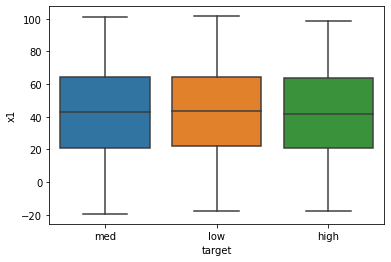

In [5]:
sns.boxplot(y=df['x1'], x=df['target'])

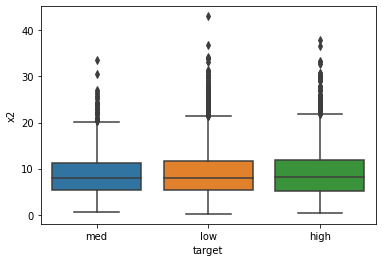

In [6]:
sns.boxplot(y=df['x2'], x=df['target'])

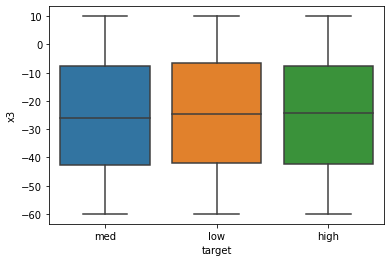

In [7]:
sns.boxplot(y=df['x3'], x=df['target'])

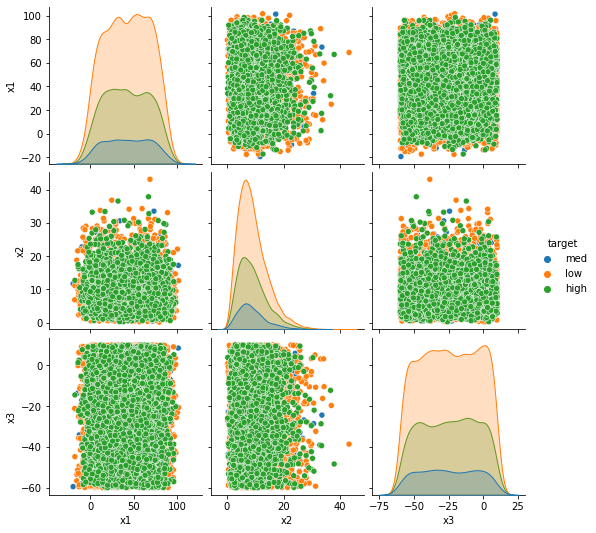

In [8]:
sns.pairplot(df, hue='target')

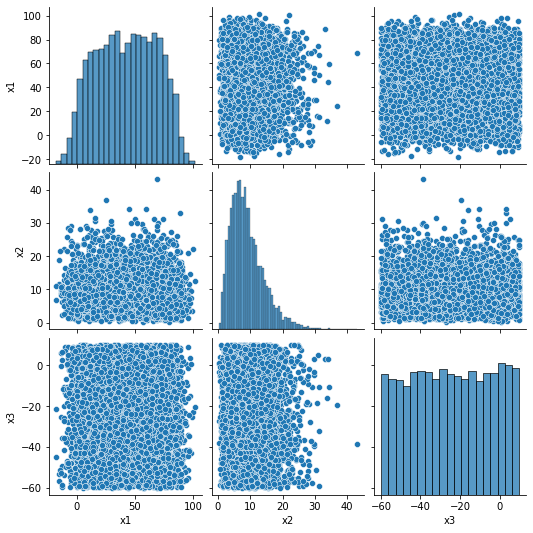

In [9]:
sns.pairplot(df.query('target == "low"'))

In [10]:
df['x13'] = df['x1']/df['x3']
df['x23'] = df['x2']/df['x3']
df['x12'] = df['x1']/df['x2']
df['x1^2'] = df['x1']**2
df['x2^2'] = df['x2']**2
df['x3^2'] = df['x3']**2
df['x1^3'] = df['x1']**3
df['x2^3'] = df['x2']**3
df['x3^3'] = df['x3']**3
df['log(x1-min(x1)+1)'] = (df['x1']-df['x1'].min()+1).transform(np.log)
df['log(x2-min(x2)+1)'] = (df['x2']-df['x2'].min()+1).transform(np.log)
df['log(x3-min(x3)+1)'] = (df['x3']-df['x3'].min()+1).transform(np.log)
df.describe()

,x1,x2,x3,x13,x23,x12,x1^2,x2^2,x3^2,x1^3,x2^3,x3^3,log(x1-min(x1)+1),log(x2-min(x2)+1),log(x3-min(x3)+1)
count,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,42.67,9.02,-24.60,inf,inf,7.23,"2,475.88",108.25,"1,010.84","161,189.01","1,614.74","-45,026.37",4.04,2.15,3.34
std,25.60,5.18,20.14,NaN,NaN,10.32,"2,264.39",130.17,"1,065.01","190,488.67","3,299.24","59,111.58",0.49,0.55,0.85
min,-19.50,0.17,-59.98,"-7,408.00",-635.00,-5.56,0.00,0.03,0.00,"-7,414.88",0.00,"-215,784.07",0.00,0.00,0.00
25%,21.68,5.26,-41.92,-2.47,-0.52,2.34,469.81,27.67,72.42,"10,183.04",145.53,"-73,665.45",3.74,1.81,2.95
50%,42.94,8.07,-24.55,-1.20,-0.24,4.92,"1,843.84",65.21,602.95,"79,174.66",526.54,"-14,805.39",4.15,2.19,3.60
75%,64.13,11.73,-7.08,-0.35,-0.11,8.85,"4,113.30",137.59,"1,757.29","263,806.40","1,613.96",-354.89,4.44,2.53,3.99
max,101.52,43.08,9.99,inf,inf,466.24,"10,306.31","1,855.89","3,597.60","1,046,296.63","79,951.59",997.00,4.80,3.78,4.26


In [11]:
df.loc[df['x3'] == 0]

,x1,x2,x3,target,x13,x23,x12,x1^2,x2^2,x3^2,x1^3,x2^3,x3^3,log(x1-min(x1)+1),log(x2-min(x2)+1),log(x3-min(x3)+1)
5372,45.88,11.47,0.00,low,inf,inf,4.00,"2,104.97",131.56,0.00,"96,576.23","1,509.00",0.00,4.20,2.51,4.11


In [12]:
df.loc[df['x3'] == 0, 'x13'] = df.loc[df['x13'] != np.inf, 'x13'].max()+1
df.loc[df['x3'] == 0, 'x23'] = df.loc[df['x23'] != np.inf, 'x23'].max()+1
df.describe()

,x1,x2,x3,x13,x23,x12,x1^2,x2^2,x3^2,x1^3,x2^3,x3^3,log(x1-min(x1)+1),log(x2-min(x2)+1),log(x3-min(x3)+1)
count,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,42.67,9.02,-24.60,-0.13,0.42,7.23,"2,475.88",108.25,"1,010.84","161,189.01","1,614.74","-45,026.37",4.04,2.15,3.34
std,25.60,5.18,20.14,182.91,46.58,10.32,"2,264.39",130.17,"1,065.01","190,488.67","3,299.24","59,111.58",0.49,0.55,0.85
min,-19.50,0.17,-59.98,"-7,408.00",-635.00,-5.56,0.00,0.03,0.00,"-7,414.88",0.00,"-215,784.07",0.00,0.00,0.00
25%,21.68,5.26,-41.92,-2.47,-0.52,2.34,469.81,27.67,72.42,"10,183.04",145.53,"-73,665.45",3.74,1.81,2.95
50%,42.94,8.07,-24.55,-1.20,-0.24,4.92,"1,843.84",65.21,602.95,"79,174.66",526.54,"-14,805.39",4.15,2.19,3.60
75%,64.13,11.73,-7.08,-0.35,-0.11,8.85,"4,113.30",137.59,"1,757.29","263,806.40","1,613.96",-354.89,4.44,2.53,3.99
max,101.52,43.08,9.99,"7,430.00","2,620.00",466.24,"10,306.31","1,855.89","3,597.60","1,046,296.63","79,951.59",997.00,4.80,3.78,4.26


In [194]:
df['target_med'] = 0
df.loc[df['target']=="med", 'target_med'] = 1
df['target_high'] = 0
df.loc[df['target']=="high", 'target_high'] = 1
df.describe()

,x1,x2,x3,x13,x23,x12,x1^2,x2^2,x3^2,x1^3,x2^3,x3^3,log(x1-min(x1)+1),log(x2-min(x2)+1),log(x3-min(x3)+1),target_low,target_high,target_med
count,"10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000"
mean,42.6696,9.0232,-24.6032,-0.1279,0.4208,7.2286,"2,475.8802",108.2501,"1,010.8393","161,189.0132","1,614.7412","-45,026.3697",4.0428,2.1484,3.3392,0.6000,0.3000,0.1000
std,25.5978,5.1802,20.1386,182.9124,46.5787,10.3192,"2,264.3881",130.1708,"1,065.0106","190,488.6713","3,299.2364","59,111.5780",0.4903,0.5457,0.8520,0.4899,0.4583,0.3000
min,-19.5000,0.1700,-59.9800,"-7,408.0000",-635.0000,-5.5574,0.0000,0.0289,0.0000,"-7,414.8750",0.0049,"-215,784.0720",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,21.6750,5.2600,-41.9200,-2.4707,-0.5224,2.3449,469.8057,27.6676,72.4201,"10,183.0418",145.5316,"-73,665.4459",3.7418,1.8066,2.9476,0.0000,0.0000,0.0000
50%,42.9400,8.0750,-24.5550,-1.2042,-0.2391,4.9164,"1,843.8437",65.2057,602.9480,"79,174.6571",526.5360,"-14,805.3906",4.1501,2.1866,3.5953,1.0000,0.0000,0.0000
75%,64.1350,11.7300,-7.0800,-0.3453,-0.1061,8.8535,"4,113.2983",137.5929,"1,757.2864","263,806.3961","1,613.9647",-354.8949,4.4383,2.5305,3.9871,1.0000,1.0000,0.0000
max,101.5200,43.0800,9.9900,"7,430.0000","2,620.0000",466.2353,"10,306.3104","1,855.8864","3,597.6004","1,046,296.6318","79,951.5861",997.0030,4.8042,3.7821,4.2623,1.0000,1.0000,1.0000


In [14]:
df.corr()

,x1,x2,x3,x13,x23,x12,x1^2,x2^2,x3^2,x1^3,x2^3,x3^3,log(x1-min(x1)+1),log(x2-min(x2)+1),log(x3-min(x3)+1),target_low,target_high
x1,1.00,-0.01,-0.01,-0.00,0.00,0.43,0.96,-0.01,0.01,0.90,-0.01,-0.00,0.96,-0.02,-0.01,0.01,-0.01
x2,-0.01,1.00,0.00,0.02,0.03,-0.42,-0.01,0.95,-0.00,-0.01,0.82,0.00,-0.02,0.94,0.00,0.00,0.01
x3,-0.01,0.00,1.00,0.01,0.02,-0.00,-0.01,-0.01,-0.94,-0.01,-0.01,0.88,-0.01,0.01,0.91,0.01,-0.00
x13,-0.00,0.02,0.01,1.00,0.78,-0.00,-0.00,0.02,-0.00,-0.00,0.02,0.00,-0.00,0.02,0.01,0.01,-0.01
x23,0.00,0.03,0.02,0.78,1.00,-0.01,-0.00,0.04,-0.01,-0.00,0.04,0.01,0.01,0.02,0.01,0.00,-0.01
x12,0.43,-0.42,-0.00,-0.00,-0.01,1.00,0.42,-0.30,-0.00,0.39,-0.21,0.00,0.41,-0.56,0.00,0.01,-0.01
x1^2,0.96,-0.01,-0.01,-0.00,-0.00,0.42,1.00,-0.00,0.01,0.98,-0.00,-0.01,0.85,-0.01,-0.01,0.01,-0.01
x2^2,-0.01,0.95,-0.01,0.02,0.04,-0.30,-0.00,1.00,0.00,-0.00,0.96,-0.00,-0.02,0.79,-0.00,0.00,0.01
x3^2,0.01,-0.00,-0.94,-0.00,-0.01,-0.00,0.01,0.00,1.00,0.01,0.01,-0.99,0.01,-0.01,-0.98,-0.00,-0.01
x1^3,0.90,-0.01,-0.01,-0.00,-0.00,0.39,0.98,-0.00,0.01,1.00,0.00,-0.01,0.77,-0.01,-0.01,0.01,-0.01


In [148]:
features = ['x1','x2','x3','x13','x23','x12','x1^2','x2^2','x3^2','x1^3','x2^3','x3^3','log(x1-min(x1)+1)','log(x2-min(x2)+1)','log(x3-min(x3)+1)']
X_train, X_test, y_train, y_test = train_test_split(df[features], df['target'], stratify=df['target'], random_state=2134)
X_train = StandardScaler().fit_transform(X_train[features])
X_train_res, y_train_res = SMOTE(random_state=3124).fit_resample(X_train, y_train)
X_train_res = StandardScaler().fit_transform(X_train_res)
df_train = pd.concat([pd.DataFrame(X_train_res), pd.Series(y_train_res)], axis=1)
df_train.target.value_counts()

low     4500
med     4500
high    4500
Name: target, dtype: int64

In [41]:
rfc = RandomForestClassifier(n_estimators = 1000)
rfc.fit(X_train_res, y_train_res)
pd.concat([pd.Series(features),pd.Series(rfc.feature_importances_)], axis=1).set_index(0).T

,x1,x2,x3,x13,x23,x12,x1^2,x2^2,x3^2,x1^3,x2^3,x3^3,log(x1-min(x1)+1),log(x2-min(x2)+1),log(x3-min(x3)+1)
1,0.0645,0.0621,0.0656,0.0748,0.0732,0.0761,0.0659,0.0615,0.0666,0.0658,0.0628,0.0679,0.0652,0.0625,0.0655


In [43]:
print('\n', classification_report(y_test, rfc.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

        high       0.32      0.02      0.04       750
         low       0.60      0.97      0.74      1500
         med       0.00      0.00      0.00       250

    accuracy                           0.59      2500
   macro avg       0.30      0.33      0.26      2500
weighted avg       0.45      0.59      0.46      2500



In [45]:
rc = remove_corr(corr_maxima=.95)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,0,1,2,3,4,5,7,8,13
0,1.0000,-0.0055,0.0006,-0.0246,-0.0107,0.4420,0.0001,-0.0096,-0.0121
1,-0.0055,1.0000,-0.0217,0.0185,0.0285,-0.4331,0.9490,0.0135,0.9419
2,0.0006,-0.0217,1.0000,-0.0131,0.0112,0.0109,-0.0254,-0.9410,-0.0166
3,-0.0246,0.0185,-0.0131,1.0000,0.7280,-0.0108,0.0193,0.0149,0.0144
4,-0.0107,0.0285,0.0112,0.7280,1.0000,-0.0075,0.0343,-0.0048,0.0200
5,0.4420,-0.4331,0.0109,-0.0108,-0.0075,1.0000,-0.3082,-0.0149,-0.5758
7,0.0001,0.9490,-0.0254,0.0193,0.0343,-0.3082,1.0000,0.0148,0.8010
8,-0.0096,0.0135,-0.9410,0.0149,-0.0048,-0.0149,0.0148,1.0000,0.0119
13,-0.0121,0.9419,-0.0166,0.0144,0.0200,-0.5758,0.8010,0.0119,1.0000


In [80]:
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])

['x1', 'x2', 'x3', 'x13', 'x23', 'x12', 'x2^2', 'x3^2', 'log(x2-min(x2)+1)']

In [101]:
rfc = RandomForestClassifier(n_estimators = 1000)
rfc.fit(X_train_res_, y_train_res)
pd.concat([pd.Series(select),pd.Series(rfc.feature_importances_)], axis=1).set_index(0).sort_values(by=1, ascending=False).T

,x1,x12,x13,x3^2,x3,x23,x2^2,log(x2-min(x2)+1),x2
1,0.1344,0.1253,0.1224,0.1149,0.1143,0.1120,0.0925,0.0925,0.0917


In [88]:
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

        high       0.30      0.21      0.25       750
         low       0.61      0.17      0.27      1500
         med       0.10      0.64      0.18       250

    accuracy                           0.23      2500
   macro avg       0.34      0.34      0.23      2500
weighted avg       0.47      0.23      0.25      2500



In [102]:
rc = remove_corr(corr_maxima=.9)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_2 = rc.transform(pd.DataFrame(X_train_res))
X_train_res_2.corr()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,0,1,2,3,4,5
0,1.0000,-0.0055,0.0006,-0.0246,-0.0107,0.4420
1,-0.0055,1.0000,-0.0217,0.0185,0.0285,-0.4331
2,0.0006,-0.0217,1.0000,-0.0131,0.0112,0.0109
3,-0.0246,0.0185,-0.0131,1.0000,0.7280,-0.0108
4,-0.0107,0.0285,0.0112,0.7280,1.0000,-0.0075
5,0.4420,-0.4331,0.0109,-0.0108,-0.0075,1.0000


In [106]:
select = []
for item in list(X_train_res_2.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000)
rfc.fit(X_train_res_2, y_train_res)
pd.concat([pd.Series(select),pd.Series(rfc.feature_importances_)], axis=1).set_index(0).sort_values(by=1, ascending=False).T

,x1,x3,x2,x12,x13,x23
1,0.1739,0.1736,0.1701,0.1647,0.1589,0.1589


In [107]:
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

        high       0.36      0.07      0.11       750
         low       0.60      0.88      0.72      1500
         med       0.07      0.05      0.06       250

    accuracy                           0.55      2500
   macro avg       0.34      0.33      0.30      2500
weighted avg       0.48      0.55      0.47      2500



In [116]:
rc = remove_corr(corr_maxima=.024)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_3 = rc.transform(pd.DataFrame(X_train_res))
X_train_res_3.corr()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,0,1,2
0,1.0000,-0.0055,0.0006
1,-0.0055,1.0000,-0.0217
2,0.0006,-0.0217,1.0000


In [119]:
select = []
for item in list(X_train_res_3.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000)
rfc.fit(X_train_res_3, y_train_res)
pd.concat([pd.Series(select),pd.Series(rfc.feature_importances_)], axis=1).set_index(0).sort_values(by=1, ascending=False).T

,x3,x1,x2
1,0.3373,0.3365,0.3262


In [123]:
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

        high       0.31      0.03      0.06       750
         low       0.60      0.96      0.74      1500
         med       0.00      0.00      0.00       250

    accuracy                           0.59      2500
   macro avg       0.30      0.33      0.27      2500
weighted avg       0.45      0.59      0.46      2500



In [134]:
dc = DummyClassifier().fit(pd.DataFrame(X_train)[[0,1,2]], y_train)
print('\n', classification_report(y_test, dc.predict(X_test[select])))


               precision    recall  f1-score   support

        high       0.00      0.00      0.00       750
         low       0.60      1.00      0.75      1500
         med       0.00      0.00      0.00       250

    accuracy                           0.60      2500
   macro avg       0.20      0.33      0.25      2500
weighted avg       0.36      0.60      0.45      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [149]:
features_train = features
features_train.extend(df_train.columns[-1:])
features_train

['x1',
 'x2',
 'x3',
 'x13',
 'x23',
 'x12',
 'x1^2',
 'x2^2',
 'x3^2',
 'x1^3',
 'x2^3',
 'x3^3',
 'log(x1-min(x1)+1)',
 'log(x2-min(x2)+1)',
 'log(x3-min(x3)+1)',
 'target']

In [150]:
df_train.columns = features_train
df_train.head()

,x1,x2,x3,x13,x23,x12,x1^2,x2^2,x3^2,x1^3,x2^3,x3^3,log(x1-min(x1)+1),log(x2-min(x2)+1),log(x3-min(x3)+1),target
0,-1.6635,0.2423,-0.4765,0.0149,-0.0112,-0.6827,-1.0887,-0.0194,0.1483,-0.8426,-0.1595,0.0856,-2.0784,0.4740,-0.0591,low
1,-0.3322,4.1626,-0.1999,0.0075,-0.0277,-0.5765,-0.5777,6.3670,-0.1805,-0.6359,8.1916,0.3652,-0.0838,2.3769,0.1621,med
2,1.7304,-0.6832,-0.8517,0.0020,-0.0075,0.8106,2.2440,-0.6024,0.6878,2.6002,-0.4403,-0.4695,1.2921,-0.5578,-0.4473,low
3,-1.5569,-1.3517,1.4696,0.0181,0.0041,-0.5602,-1.0857,-0.8037,-0.9249,-0.8425,-0.4884,0.7632,-1.8234,-2.0046,0.9957,high
4,0.6038,-1.2203,0.7712,-0.0248,-0.0112,1.3293,0.3969,-0.7787,-0.8725,0.1821,-0.4848,0.7486,0.6563,-1.6159,0.7152,high


In [154]:
df_train.target.replace('low', -1, inplace=True)
df_train.target.replace('med', 0, inplace=True)
df_train.target.replace('high', 1, inplace=True)
df_train.target.value_counts().to_frame()

,target
-1,4500
0,4500
1,4500


In [158]:
df_test = pd.concat([pd.DataFrame(X_test), pd.Series(y_test)], axis=1)
df_test.target.replace('low', -1, inplace=True)
df_test.target.replace('med', 0, inplace=True)
df_test.target.replace('high', 1, inplace=True)
df_test.target.value_counts().to_frame()

,target
-1,1500
1,750
0,250


In [192]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res, columns=features[:15]), df_train.target)

In [198]:
print('\n', classification_report(df_test.target, xgbc.predict(X_test)))


               precision    recall  f1-score   support

          -1       0.54      0.06      0.11      1500
           0       0.10      0.68      0.17       250
           1       0.27      0.22      0.25       750

    accuracy                           0.17      2500
   macro avg       0.31      0.32      0.17      2500
weighted avg       0.42      0.17      0.15      2500



In [257]:
features = ['x1','x2','x3','x13','x23','x12','x1^2','x2^2','x3^2','x1^3','x2^3','x3^3','log(x1-min(x1)+1)','log(x2-min(x2)+1)','log(x3-min(x3)+1)']
X_train, X_test, y_train, y_test = train_test_split(df[features], df['target_med'], stratify=df['target_med'], random_state=2134)
X_train = StandardScaler().fit_transform(X_train[features])
X_train_res, y_train_res = SMOTE(random_state=3124).fit_resample(X_train, y_train)
X_train_res = StandardScaler().fit_transform(X_train_res)
df_train = pd.concat([pd.DataFrame(X_train_res), pd.Series(y_train_res)], axis=1)
df_train.target_med.value_counts()

0    6750
1    6750
Name: target_med, dtype: int64

ter um modelo de referencia (dumies)

precisa equilibrar a base

In [258]:
dc = DummyClassifier().fit(pd.DataFrame(X_train)[[0,1,2]], y_train)
print('\n', classification_report(y_test, dc.predict(X_test.iloc[:,:3])))


               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2250
           1       0.00      0.00      0.00       250

    accuracy                           0.90      2500
   macro avg       0.45      0.50      0.47      2500
weighted avg       0.81      0.90      0.85      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [259]:
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2250
           1       0.00      0.00      0.00       250

    accuracy                           0.90      2500
   macro avg       0.45      0.50      0.47      2500
weighted avg       0.81      0.90      0.85      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [260]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res, columns=features[:15]), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test)))


               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2250
           1       0.00      0.00      0.00       250

    accuracy                           0.90      2500
   macro avg       0.45      0.50      0.47      2500
weighted avg       0.81      0.90      0.85      2500



In [261]:
rc = remove_corr(corr_maxima=.95)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2250
           1       0.00      0.00      0.00       250

    accuracy                           0.90      2500
   macro avg       0.45      0.50      0.47      2500
weighted avg       0.81      0.90      0.85      2500



In [262]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2250
           1       0.00      0.00      0.00       250

    accuracy                           0.90      2500
   macro avg       0.45      0.50      0.47      2500
weighted avg       0.81      0.90      0.85      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [263]:
rc = remove_corr(corr_maxima=.9)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2250
           1       0.00      0.00      0.00       250

    accuracy                           0.90      2500
   macro avg       0.45      0.50      0.47      2500
weighted avg       0.81      0.90      0.85      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [264]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2250
           1       0.00      0.00      0.00       250

    accuracy                           0.90      2500
   macro avg       0.45      0.50      0.47      2500
weighted avg       0.81      0.90      0.85      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [265]:
rc = remove_corr(corr_maxima=.85)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2250
           1       0.00      0.00      0.00       250

    accuracy                           0.90      2500
   macro avg       0.45      0.50      0.47      2500
weighted avg       0.81      0.90      0.85      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [266]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2250
           1       0.00      0.00      0.00       250

    accuracy                           0.90      2500
   macro avg       0.45      0.50      0.47      2500
weighted avg       0.81      0.90      0.85      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [267]:
rc = remove_corr(corr_maxima=.8)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2250
           1       0.00      0.00      0.00       250

    accuracy                           0.90      2500
   macro avg       0.45      0.50      0.47      2500
weighted avg       0.81      0.90      0.85      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [268]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2250
           1       0.00      0.00      0.00       250

    accuracy                           0.90      2500
   macro avg       0.45      0.50      0.47      2500
weighted avg       0.81      0.90      0.85      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [244]:
features = ['x1','x2','x3','x13','x23','x12','x1^2','x2^2','x3^2','x1^3','x2^3','x3^3','log(x1-min(x1)+1)','log(x2-min(x2)+1)','log(x3-min(x3)+1)']
X_train, X_test, y_train, y_test = train_test_split(df[features], df['target_high'], stratify=df['target_high'], random_state=2134)
X_train = StandardScaler().fit_transform(X_train[features])
X_train_res, y_train_res = SMOTE(random_state=3124).fit_resample(X_train, y_train)
X_train_res = StandardScaler().fit_transform(X_train_res)
df_train = pd.concat([pd.DataFrame(X_train_res), pd.Series(y_train_res)], axis=1)
df_train.target_high.value_counts()

0    5250
1    5250
Name: target_high, dtype: int64

In [245]:
dc = DummyClassifier().fit(pd.DataFrame(X_train)[[0,1,2]], y_train)
print('\n', classification_report(y_test, dc.predict(X_test.iloc[:,:3])))


               precision    recall  f1-score   support

           0       0.70      1.00      0.82      1750
           1       0.00      0.00      0.00       750

    accuracy                           0.70      2500
   macro avg       0.35      0.50      0.41      2500
weighted avg       0.49      0.70      0.58      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [246]:
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.70      1.00      0.82      1750
           1       0.00      0.00      0.00       750

    accuracy                           0.70      2500
   macro avg       0.35      0.50      0.41      2500
weighted avg       0.49      0.70      0.58      2500



In [247]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res, columns=features[:15]), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test)))


               precision    recall  f1-score   support

           0       0.70      0.95      0.81      1750
           1       0.34      0.06      0.10       750

    accuracy                           0.68      2500
   macro avg       0.52      0.50      0.45      2500
weighted avg       0.59      0.68      0.60      2500



In [248]:
rc = remove_corr(corr_maxima=.95)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.70      0.24      0.35      1750
           1       0.30      0.76      0.43       750

    accuracy                           0.39      2500
   macro avg       0.50      0.50      0.39      2500
weighted avg       0.58      0.39      0.38      2500



In [249]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.70      1.00      0.82      1750
           1       0.00      0.00      0.00       750

    accuracy                           0.70      2500
   macro avg       0.35      0.50      0.41      2500
weighted avg       0.49      0.70      0.58      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [250]:
rc = remove_corr(corr_maxima=.9)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.69      0.68      0.68      1750
           1       0.28      0.29      0.29       750

    accuracy                           0.56      2500
   macro avg       0.49      0.48      0.48      2500
weighted avg       0.57      0.56      0.56      2500



In [251]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.70      1.00      0.82      1750
           1       0.00      0.00      0.00       750

    accuracy                           0.70      2500
   macro avg       0.35      0.50      0.41      2500
weighted avg       0.49      0.70      0.58      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [252]:
rc = remove_corr(corr_maxima=.85)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.70      0.85      0.77      1750
           1       0.30      0.15      0.20       750

    accuracy                           0.64      2500
   macro avg       0.50      0.50      0.48      2500
weighted avg       0.58      0.64      0.60      2500



In [253]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.70      1.00      0.82      1750
           1       0.00      0.00      0.00       750

    accuracy                           0.70      2500
   macro avg       0.35      0.50      0.41      2500
weighted avg       0.49      0.70      0.58      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [254]:
rc = remove_corr(corr_maxima=.8)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.70      0.32      0.44      1750
           1       0.30      0.68      0.42       750

    accuracy                           0.43      2500
   macro avg       0.50      0.50      0.43      2500
weighted avg       0.58      0.43      0.43      2500



In [255]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.70      1.00      0.82      1750
           1       0.00      0.00      0.00       750

    accuracy                           0.70      2500
   macro avg       0.35      0.50      0.41      2500
weighted avg       0.49      0.70      0.58      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [275]:
features = ['x1','x2','x3','x13','x23','x12','x1^2','x2^2','x3^2','x1^3','x2^3','x3^3','log(x1-min(x1)+1)','log(x2-min(x2)+1)','log(x3-min(x3)+1)']
X_train, X_test, y_train, y_test = train_test_split(df[features], df['target_low'], stratify=df['target_low'], random_state=2134)
X_train = StandardScaler().fit_transform(X_train[features])
X_train_res, y_train_res = SMOTE(random_state=3124).fit_resample(X_train, y_train)
X_train_res = StandardScaler().fit_transform(X_train_res)
df_train = pd.concat([pd.DataFrame(X_train_res), pd.Series(y_train_res)], axis=1)
df_train.target_low.value_counts()

1    4500
0    4500
Name: target_low, dtype: int64

In [276]:
dc = DummyClassifier().fit(pd.DataFrame(X_train)[[0,1,2]], y_train)
print('\n', classification_report(y_test, dc.predict(X_test.iloc[:,:3])))


               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.60      1.00      0.75      1500

    accuracy                           0.60      2500
   macro avg       0.30      0.50      0.37      2500
weighted avg       0.36      0.60      0.45      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [277]:
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.33      0.01      0.02      1000
           1       0.60      0.99      0.75      1500

    accuracy                           0.60      2500
   macro avg       0.47      0.50      0.38      2500
weighted avg       0.49      0.60      0.45      2500



In [278]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res, columns=features[:15]), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test)))


               precision    recall  f1-score   support

           0       0.40      0.80      0.54      1000
           1       0.61      0.21      0.31      1500

    accuracy                           0.44      2500
   macro avg       0.51      0.50      0.42      2500
weighted avg       0.53      0.44      0.40      2500



In [279]:
rc = remove_corr(corr_maxima=.9)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.35      0.01      0.01      1000
           1       0.60      0.99      0.75      1500

    accuracy                           0.60      2500
   macro avg       0.48      0.50      0.38      2500
weighted avg       0.50      0.60      0.45      2500



In [280]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.40      1.00      0.57      1000
           1       0.00      0.00      0.00      1500

    accuracy                           0.40      2500
   macro avg       0.20      0.50      0.29      2500
weighted avg       0.16      0.40      0.23      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [281]:
rc = remove_corr(corr_maxima=.85)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.25      0.00      0.01      1000
           1       0.60      0.99      0.75      1500

    accuracy                           0.60      2500
   macro avg       0.42      0.50      0.38      2500
weighted avg       0.46      0.60      0.45      2500



In [282]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.40      1.00      0.57      1000
           1       0.00      0.00      0.00      1500

    accuracy                           0.40      2500
   macro avg       0.20      0.50      0.29      2500
weighted avg       0.16      0.40      0.23      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [283]:
rc = remove_corr(corr_maxima=.95)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.39      0.34      0.36      1000
           1       0.59      0.64      0.62      1500

    accuracy                           0.52      2500
   macro avg       0.49      0.49      0.49      2500
weighted avg       0.51      0.52      0.52      2500



In [284]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.40      1.00      0.57      1000
           1       0.00      0.00      0.00      1500

    accuracy                           0.40      2500
   macro avg       0.20      0.50      0.29      2500
weighted avg       0.16      0.40      0.23      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [285]:
rc = remove_corr(corr_maxima=.8)
rc.fit(pd.DataFrame(X_train_res), y_train_res)
X_train_res_ = rc.transform(pd.DataFrame(X_train_res))
X_train_res_.corr()
select = []
for item in list(X_train_res_.columns.values):
  select.append(features[item])
rfc = RandomForestClassifier(n_estimators = 1000).fit(X_train_res_, y_train_res)
print('\n', classification_report(y_test, rfc.predict(X_test[select])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



               precision    recall  f1-score   support

           0       0.25      0.00      0.00      1000
           1       0.60      1.00      0.75      1500

    accuracy                           0.60      2500
   macro avg       0.42      0.50      0.38      2500
weighted avg       0.46      0.60      0.45      2500



In [286]:
xgbc = xgb.XGBClassifier().fit(pd.DataFrame(X_train_res_, columns=select), y_train_res)
print('\n', classification_report(y_test, xgbc.predict(X_test[select])))


               precision    recall  f1-score   support

           0       0.40      1.00      0.57      1000
           1       0.00      0.00      0.00      1500

    accuracy                           0.40      2500
   macro avg       0.20      0.50      0.29      2500
weighted avg       0.16      0.40      0.23      2500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
